## Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from reproduction import *
from data_processing import *
from constants import *

## Data Processing

In [2]:
full_logistics_data_df = load_full_logistics_data()
full_order_data_df = load_full_order_data()

In [3]:
distribution_difference = compute_action_time_distribution_difference(full_logistics_data_df, full_order_data_df, bin_size=0.04)
distribution_difference

,logistics_review_score,action,action_time_interval,conditional_density,unconditional_density,distribution_difference
0,2.0,ARRIVAL,0.00,0.004012,0.000863,0.003149
1,2.0,ARRIVAL,0.04,0.015925,0.007249,0.008676
2,2.0,ARRIVAL,0.08,0.021973,0.014237,0.007736
3,2.0,ARRIVAL,0.12,0.024432,0.018526,0.005906
4,2.0,ARRIVAL,0.16,0.026115,0.020311,0.005805
...,...,...,...,...,...,...
499,5.0,SENT_SCAN,0.84,0.121715,0.121471,0.000243
500,5.0,SENT_SCAN,0.88,0.133948,0.133684,0.000265
501,5.0,SENT_SCAN,0.92,0.131534,0.131409,0.000126
502,5.0,SENT_SCAN,0.96,0.141968,0.142511,-0.000543


## Plot

<Figure size 1200x800 with 0 Axes>

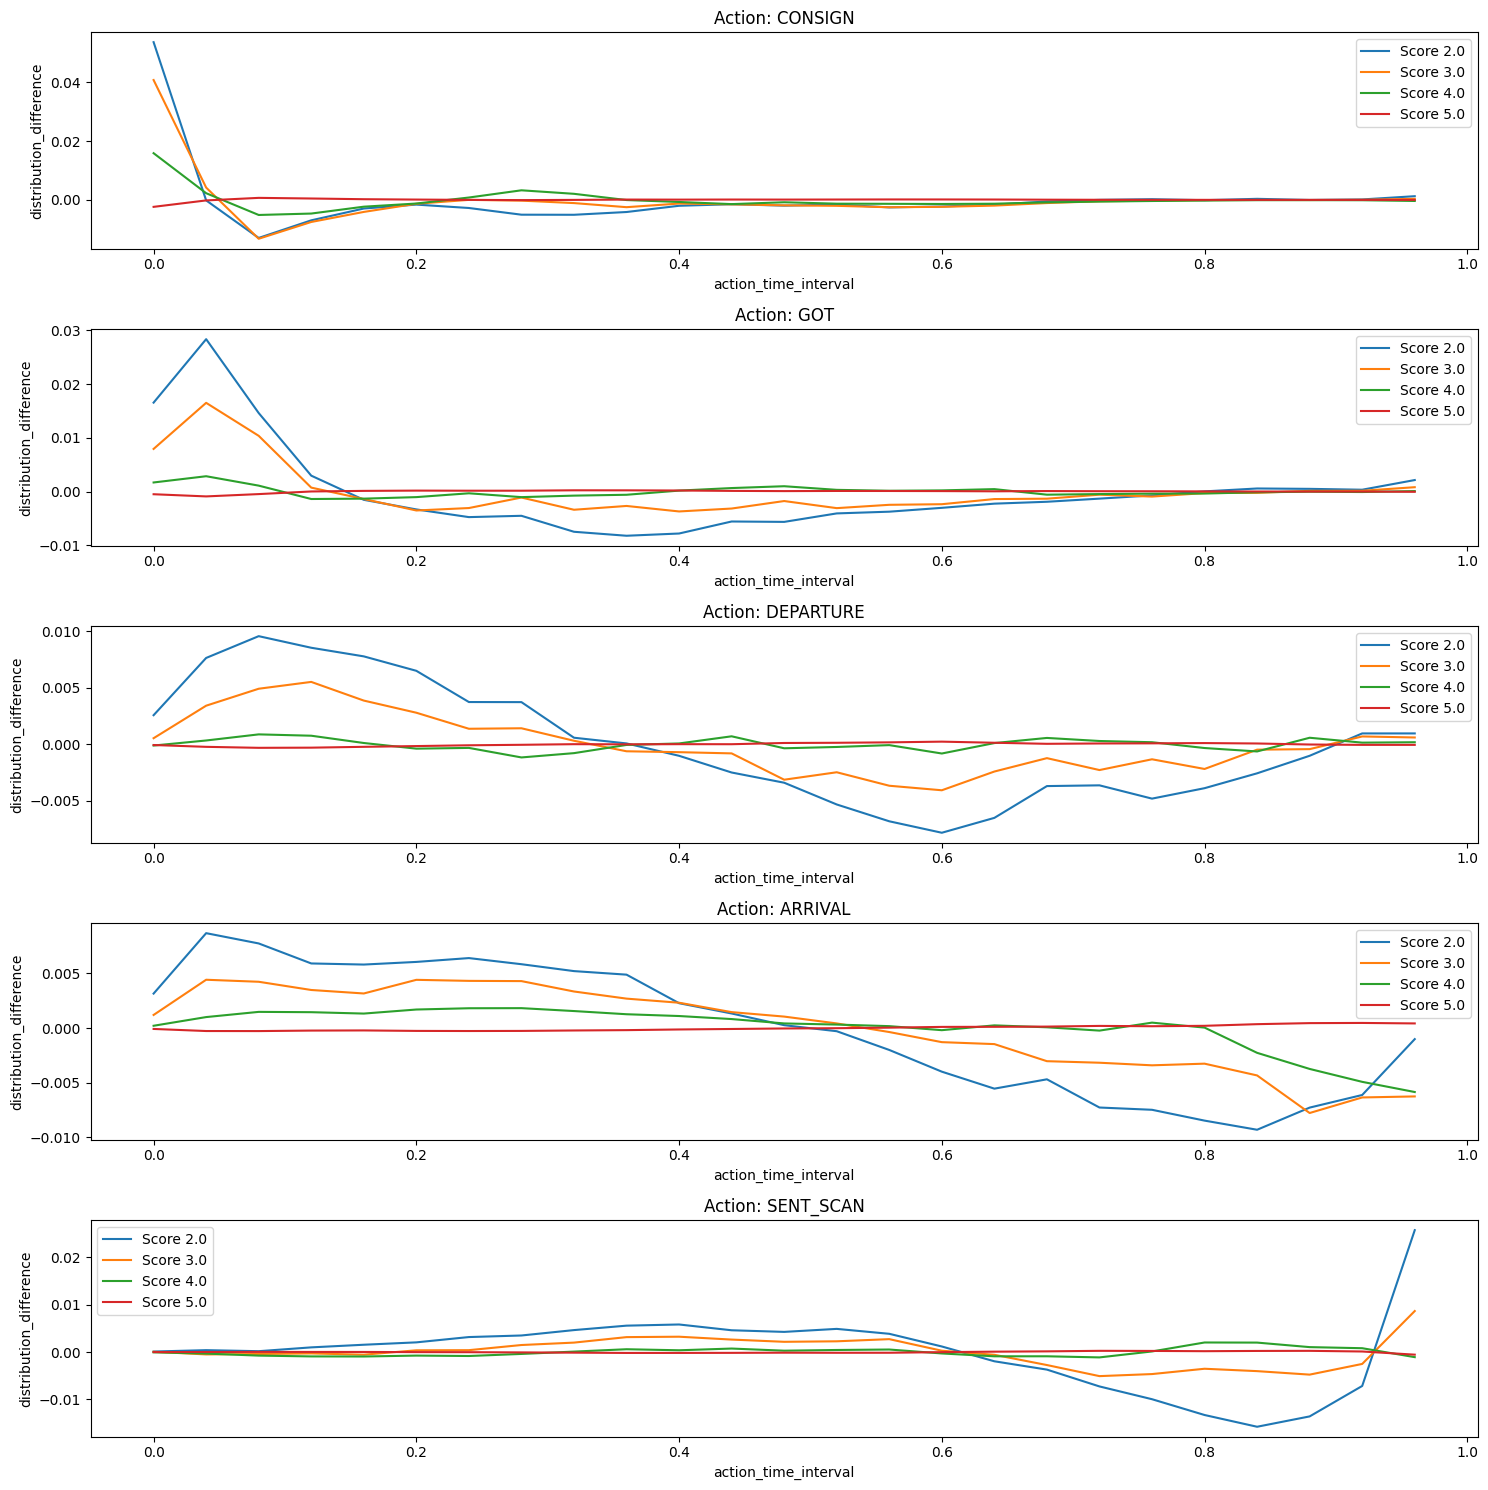

In [4]:
# Plot
plt.figure(figsize=(12, 8))
actions = [CONSIGN, GOT, DEPARTURE, ARRIVAL, SENT_SCAN]

# Define the number of rows/cols for the subplot grid
cols = 1
rows = len(actions)

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows)) 
axs = axs.flatten()  # Flatten the axis array for easy iteration if it's 2D

for idx, action in enumerate(actions):
    subset = distribution_difference[distribution_difference[ACTION] == action]
    
    for score in subset[LOGISTICS_REVIEW_SCORE].unique():
        score_subset = subset[subset[LOGISTICS_REVIEW_SCORE] == score]
        # Plot on the subplot axes
        sns.lineplot(x=ACTION_TIME_INTERVAL, y=DISTRIBUTION_DIFFERENCE, data=score_subset, label=f'Score {score}', ax=axs[idx])
    
    axs[idx].set_title(f"Action: {action}")
    axs[idx].legend()

# Adjust layout
plt.tight_layout()
plt.show()